## refer to: https://www.kaggle.com/raddar/paris-madness
- https://www.ncaa.com/brackets/basketball-women/d1/2017

# import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold, GroupKFold, train_test_split
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections
import datetime
import copy
import mlflow
from sklearn import preprocessing
import lightgbm as lgb
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance

pd.set_option("display.max_column", 999)
# print(os.listdir("../input"))

/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/eli5/base_utils.py:28: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  init_args = inspect.getargspec(class_.__init_

# setting mlflow

In [2]:
# class Mlflow_Config:
    
#     def __init__(self, uri='../mlflow/mlruns/'):
#         mlflow.set_tracking_uri(uri)
#         self.tracking = mlflow.tracking.MlflowClient()
#         print('experiment_name:', *[i.name for i in self.tracking.list_experiments()], sep='\n\t')
    
#     @staticmethod
#     def set_experiment(experiment_name):
#         # こういうのって必要？明示的に書いておいたけど。。。
#         mlflow.set_experiment(experiment_name)

# trial = Mlflow_Config()
# trial.set_experiment('booster')

In [2]:
tracking = mlflow.tracking.MlflowClient()
print('experiment_name:', *[i.name for i in tracking.list_experiments()], sep='\n\t')

experiment_name:
	Default


/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/yaml/constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if not isinstance(key, collections.Hashable):


In [156]:
add_params = {
    'random_seed': 'ON',
    'repeat_cv': '3',
    'Diff': 'OFF',
    '4factors': 'ON',
    'feature_eng': 'OFF',
    'del_basic_features': 'OFF',
    'Conference': 'ON',
    'LocationBy': 'OFF',
    'last14days_stats': 'OFF',
    'adjust_seed': 'ON',
    'groupkfold': 'ON',
    'rmse': 'OFF',
    'num_boost_round': '25',
    'duration_season': '100',
    'del_train_corr': 'OFF',
    'del_seed_diff': 'ON',
    'del_start_T12': 'OFF',
    'permtation_imp': 'OFF'
}

mlflow_config = {
    'uri': '../mlflow/mlruns/',
    'experiment_name': '4Factors',
    'add_params': add_params,
    'run_id': None
}
mlflow.set_tracking_uri(mlflow_config['uri'])
mlflow.set_experiment(mlflow_config['experiment_name'])
mlflow_config['tracking'] = mlflow.tracking.MlflowClient()
mlflow_config['experiment_id'] = mlflow_config['tracking'].get_experiment_by_name(mlflow_config['experiment_name']).experiment_id
print(mlflow_config)

{'uri': '../mlflow/mlruns/', 'experiment_name': '4Factors', 'add_params': {'random_seed': 'ON', 'repeat_cv': '3', 'Diff': 'OFF', '4factors': 'ON', 'feature_eng': 'ON', 'del_basic_features': 'OFF', 'Conference': 'ON', 'LocationBy': 'OFF', 'last14days_stats': 'OFF', 'adjust_seed': 'ON', 'groupkfold': 'ON', 'rmse': 'OFF', 'num_boost_round': '25', 'duration_season': '100', 'del_train_corr': 'OFF', 'del_seed_diff': 'ON', 'del_start_T12': 'OFF', 'permtation_imp': 'OFF'}, 'run_id': None, 'tracking': <mlflow.tracking.client.MlflowClient object at 0x10fe397b8>, 'experiment_id': '12'}


# Load the data!

In [157]:
path = '../W/input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WDataFiles_Stage1/'
submit_csv_path = '../W/input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament'
output_path = '../output/W/'

tourney_results = pd.read_csv(os.path.join(path, 'WNCAATourneyDetailedResults.csv'))
seeds = pd.read_csv(os.path.join(path, 'WNCAATourneySeeds.csv'))
regular_results = pd.read_csv(os.path.join(path, 'WRegularSeasonDetailedResults.csv'))
conferences = pd.read_csv(os.path.join(path, 'WTeamConferences.csv'))

In [158]:
sub = pd.read_csv(os.path.join(submit_csv_path, 'WSampleSubmissionStage1_2020.csv'))

def transform_test(test):
    # sub["Season"] = 2018 # なぜ2018年固定？
    test['Season'] = test['ID'].apply(lambda x: x[0:4]).astype(int)
    test["T1_TeamID"] = test["ID"].apply(lambda x: x[5:9]).astype(int)
    test["T2_TeamID"] = test["ID"].apply(lambda x: x[10:14]).astype(int)
    return test
sub = transform_test(sub)
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2015_3106_3107,0.5,2015,3106,3107
1,2015_3106_3110,0.5,2015,3106,3110
2,2015_3106_3113,0.5,2015,3106,3113
3,2015_3106_3114,0.5,2015,3106,3114
4,2015_3106_3116,0.5,2015,3106,3116


# Data preparing!

In [159]:
class Preprocessor_NCAA:
    SWAP_COLS = ['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
                                'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
                                'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']
    if mlflow_config['add_params']['feature_eng']!='ON':
        SWAP_COLS = ['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc']

    STATS_EXC_COLS = ['DayNum', 'NumOT', 'T2_TeamID', 'location']
    
    def __init__(self, regular_results, tourney_results, seeds, conferences, train_flag=True):
        self.regular_data = regular_results
        self.tourney_data = tourney_results
        self.ranking_data = self.meke_rangking_data() # rankingので０たは2013以降しかないから注意が必要？
        self.seeds = seeds
        self.conferences = self.encode_conferences_data(conferences)
        self.train_flag = train_flag

    def fit(self):
        swap_regular_data = self.swap_data(self.regular_data)
        encoded_regular_df = self.encode_detail_data(swap_regular_data)
        if mlflow_config['add_params']['4factors']=='ON':
            encoded_regular_df = self.make_4factors(encoded_regular_df)
        self.regular_data = self.feature_eng_data(encoded_regular_df)
        
        if self.train_flag:
            self.tourney_data = self.swap_data(self.tourney_data)[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]

        if mlflow_config['add_params']['del_basic_features']=='ON':
            self.regular_data = self.del_basic_features(self.regular_data)
        self.cols =  list(set(self.regular_data.columns) - set(self.STATS_EXC_COLS))
        df_list = []
        
        if mlflow_config['add_params']['LocationBy']=='ON':
            df_list.extend(self.get_data_byLocation(self.regular_data))
        last14days_stats = self.get_lastNdays_data(self.regular_data, 14)
        
        train_df = self.join_MeanValue(self.regular_data[self.cols], self.tourney_data)
        
        if mlflow_config['add_params']['last14days_stats']=='ON':
            df_list.append(last14days_stats) # 絶対もっと綺麗にかける

        for df in df_list:
            train_df = self.join_MeanValue(df, train_df)
        train_df = self.join_GLM(train_df)
        train_df = self.join_seed(train_df)
        if mlflow_config['add_params']['Conference']=='ON':
            train_df = self.join_ranking(train_df)
        
        self.features = [col for col in train_df.columns if col not in ('DayNum', 'Season', 'T1_Score', 'T1_TeamID', 'T2_Score', 'T2_TeamID') ]
        if mlflow_config['add_params']['Diff']=='ON':
            train_df = self.get_diff_stat(train_df)
        
        if self.train_flag:
            self.del_corr_feature(train_df)
        
        return train_df
    
    def del_basic_features(self, df):
        cols = ['T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF',
                                    'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',]
        df = df.drop(cols, axis=1)
        return df
    
    def del_corr_feature(self, df):
        counter = 0
        to_remove = []
        for feat_a in self.features:
            for feat_b in self.features:
                if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
                    c = np.corrcoef(df[feat_a], df[feat_b])[0][1]
                    if c > 0.995:
                        counter += 1
                        to_remove.append(feat_b)
                        print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))
        self.to_remove = to_remove
    
    def get_diff_stat(self, df):
        copy_df = df.copy()
        feature_dict = { feature: feature.replace('T1', 'T2') for feature in self.features if (feature.startswith('T1')) & (feature!='T1_seed')}
        for k, v in feature_dict.items():
            copy_df[k.replace('T1', 'Diff')] = copy_df[k] - copy_df[v]
            self.features.append(k.replace('T1', 'Diff'))
        return copy_df
    
    def swap_data(self, df):
        copy_df = df.copy()
        dfswap = copy_df[self.SWAP_COLS]
        dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
        dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
#         copy_df.columns.values[6] = 'locationXX'
#         dfswap.columns.values[6] = 'locationXX'    

        copy_df.columns = [x.replace('W','T1_').replace('L','T2_') if x!='WLoc' else 'location' for x in list(copy_df.columns)]
        dfswap.columns = [x.replace('L','T1_').replace('W','T2_') if x!='WLoc' else 'location' for x in list(dfswap.columns)]

        return pd.concat([copy_df, dfswap]).reset_index(drop=True)

    def encode_detail_data(self, df):
        df.loc[df.location=='N','location'] = '0'
        df.loc[df.location=='H','location'] = '1'
        df.loc[df.location=='A','location'] = '-1'
        df.location = df.location.astype(int)
        
        return df
    
    def encode_conferences_data(self, conferences):
        le = preprocessing.LabelEncoder()
        le.fit(conferences['ConfAbbrev'])
        conferences['ConfAbbrev'] = le.transform(conferences['ConfAbbrev'])
        return conferences
    
    def make_4factors(self, df):
        # make 4factors $ PPP, POSS
        # FYI: https://www.sportsanalyticslab.com/column/basketball-mathematics.html
        for t in ['T1', 'T2']:
            df[f'{t}_POSS'] = df[f'{t}_FGA'] - df[f'{t}_OR'] + 0.5*df[f'{t}_FTA'] + df[f'{t}_TO'] # 攻撃回数
            df[f'{t}_PPP'] = df[f'{t}_Score'] / df[f'{t}_POSS'] # 得点効率
            df[f'{t}_eFGper'] = (df[f'{t}_FGM'] + 0.5*df[f'{t}_FGM3']) / df[f'{t}_FGA'] # シュート効率、３Pに付加価値をつけている
            df[f'{t}_TOper'] = df[f'{t}_TO'] / (df[f'{t}_FGA'] + 0.5*df[f'{t}_FTA'] + df[f'{t}_TO'] )# シュートを打てずに攻撃が終わる割合
            df[f'{t}_FTR'] = df[f'{t}_FTM'] / df[f'{t}_FTA'] # フリースロー成功割合、feature_eng_data内でも作成している
        df['T1_ORBper'] = df['T1_OR'] / (df['T1_OR'] + df['T2_DR']) # オフェンスリバウンドの獲得率、feature_eng_data内でも作成している
        df['T2_ORBper'] = df['T2_OR'] / (df['T2_OR'] + df['T1_DR'])
        
        df['Diff_POSS'] = df['T1_POSS'] - df['T2_POSS']
        df['Diff_PPP'] = df['T1_PPP'] - df['T2_PPP']
        df['Diff_eFGper'] = df['T1_eFGper'] - df['T2_eFGper']
        df['Diff_TOper'] = df['T1_TOper'] - df['T2_TOper']
        df['Diff_FTR'] = df['T1_FTR'] - df['T2_FTR']
        df['Diff_ORBper'] = df['T1_ORBper'] - df['T2_ORBper']
        
        return df
    
    def feature_eng_data(self, df):
        df['PointDiff'] = df['T1_Score'] - df['T2_Score']
        # 追加
        df['T1_win'] = np.where(df['PointDiff']>0, 1, 0) # 勝ち負け
        df['T2_win'] = np.where(df['PointDiff']>0, 0, 1)
        
        
        if mlflow_config['add_params']['feature_eng']=='ON':
            for t in ['T1', 'T2']:
                df[f'{t}_FGmissed'] = df[f'{t}_FGA'] - df[f'{t}_FGM'] # シュートミス
                df[f'{t}_FGmissed3'] = df[f'{t}_FGA3'] - df[f'{t}_FGM3'] # シュートミス
                df[f'{t}_FTmissed'] = df[f'{t}_FTA'] - df[f'{t}_FTM'] # フリースローミス

                df[f'{t}_FGsuccess_ratio'] = df[f'{t}_FGM'] / df[f'{t}_FGA'] # シュート成功率
                df[f'{t}_FG3success_ratio'] = df[f'{t}_FGM3'] / df[f'{t}_FGA3'] # 3Pシュート成功率
                df[f'{t}_FTsuccess_ratio'] = df[f'{t}_FTM'] / df[f'{t}_FTA'] # フリースロー成功率

                df[f'{t}_FG2ratio'] = df[f'{t}_FGM'] / df[f'{t}_Score'] # 2点シュートの割合
                df[f'{t}_FG3ratio'] = df[f'{t}_FGM3'] / df[f'{t}_Score'] # 3Pシュートの割合
                df[f'{t}_FGratio'] = (df[f'{t}_FGM'] + df[f'{t}_FGM3']) / df[f'{t}_Score'] # FGの割合
                df[f'{t}_FTratio'] = df[f'{t}_FTM'] / df[f'{t}_Score'] # フリースローの割合

                df[f'{t}_DRratio'] = (df[f'{t}_DR'] + df[f'{t}_DR']) / (df['T1_OR'] + df['T1_DR'] + df['T2_OR'] + df['T2_DR']) # リバウンド率
                df[f'{t}_ORratio'] = df[f'{t}_OR'] / (df[f'{t}_OR'] + df[f'{t}_DR'])
                df[f'{t}_DRratio'] = df[f'{t}_DR'] / (df[f'{t}_OR'] + df[f'{t}_DR'])

                df[f'{t}_ASTratio'] = df[f'{t}_Ast'] / df[f'{t}_FGM'] # アシスト率
#                 df[f'{t}_PF_byPeriod'] = df[f'{t}_PF'] / 4 # ピリオドごとの平均、PFってこんなに多いの！？
#                 df['T1_over5PF'] = np.where(df[f'{t}_PF_byPeriod']>=5, 1, 0) # 平均が5ファウル超えているか(チームファウル)

            df['T1_ORratio_op']  = df['T1_OR'] / (df['T1_OR'] + df['T2_DR']) # 攻撃時のリバウンド、守備時のリバウンド(リストをスライスする形ならfor文に組み込めた)
            df['T1_DRratio_op']  = df['T1_DR'] / (df['T1_DR'] + df['T2_OR'])
            df['T2_ORratio_op']  = df['T2_OR'] / (df['T1_DR'] + df['T2_OR'])
            df['T2_DRratio_op']  = df['T2_DR'] / (df['T1_OR'] + df['T2_DR'])

            df['T1_FGblock'] = df['T1_Blk'] / df['T2_FGmissed'] # ブロック率
            df['T2_FGblock'] = df['T2_Blk'] / df['T1_FGmissed']
            df['T1_FGAblock'] = df['T1_Blk'] / df['T2_FGA'] # ブロック率２ どっちがいいかわからないから両方作った 
            df['T2_FGAblock'] = df['T2_Blk'] / df['T1_FGA']
            
            df["T1_chance_to_score"] = df[['T1_Blk', 'T1_Stl',  'T1_OR',  'T1_DR']].sum(axis=1) - df["T2_Stl"]
            df["T2_chance_to_score"] = df[['T2_Blk', 'T2_Stl',  'T2_OR',  'T2_DR']].sum(axis=1) - df["T1_Stl"]
        
        return df

    def join_MeanValue(self, df, toJoin_df):
        season_statistics = self.get_mean_value(df)
        season_statistics_T1 = season_statistics.copy()
        season_statistics_T2 = season_statistics.copy()

        season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") if not x == 'Season' else x for x in list(season_statistics_T1.columns)]
        season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") if not x == 'Season' else x for x in list(season_statistics_T2.columns)]
        
        toJoin_df = pd.merge(toJoin_df, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
        toJoin_df = pd.merge(toJoin_df, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')
        
        return toJoin_df

    def get_mean_value(self, df):
        keys = ["Season", 'T1_TeamID']
        funcs = [np.mean]
        
        season_statistics = df.groupby(keys).agg(funcs).reset_index()
        season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
        
        return season_statistics
    
    def get_data_byLocation(self, df):
#         home_df = df.loc[df.location ==1].reset_index(drop=True)[['Season', 'T1_TeamID', 'T1_win']]
        home_df = df.loc[df.location ==1].reset_index(drop=True)[self.cols]
        home_df = self.column_addNamed(home_df, '_location{}'.format('1'))
        
#         not_home_df = df.loc[df.location !=1].reset_index(drop=True)[['Season', 'T1_TeamID', 'T1_win']]
        not_home_df = df.loc[df.location !=1].reset_index(drop=True)[self.cols]
        not_home_df = self.column_addNamed(not_home_df, '_location{}'.format('_not1'))
        return [home_df, not_home_df]
            
    
    def get_lastNdays_data(self, df, n):
        # 追加：ここはwinかどうか以外も足していい気がする
#         lastNdays_stats = df.loc[df.DayNum>=(132-n)].reset_index(drop=True)[['Season', 'T1_TeamID', 'T1_win']]
        lastNdays_stats = df.loc[df.DayNum>=(132-n)].reset_index(drop=True)[self.cols]
        lastNdays_stats = self.column_addNamed(lastNdays_stats, '_last{}days'.format(n))
        return lastNdays_stats
    
    def column_addNamed(self, df, addName):
        not_add_cols = ['T1_TeamID', 'Season']
        df.columns = [col + addName if  col not in tuple(not_add_cols) else col for col in df.columns]
        return df
    
    def join_GLM(self, toJoin_df):
        glm_quality = self.fit_predict_GLM()
        glm_quality_T1 = glm_quality.copy()
        glm_quality_T2 = glm_quality.copy()
        glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
        glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']
        
        toJoin_df = pd.merge(toJoin_df, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
        toJoin_df = pd.merge(toJoin_df, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')
        
        return toJoin_df
        
    def fit_predict_GLM(self):
        self.make_GLMtrain()
        glm_quality = pd.concat([self.team_quality(season) for season in  range(2010, 2020)]).reset_index(drop=True)
        return glm_quality
    
    def make_GLMtrain(self):
        regular_season_effects = self.regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff', 'T1_win']].copy()
        regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
        regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
        march_madness = pd.merge(self.seeds[['Season','TeamID']],self.seeds[['Season','TeamID']],on='Season')
        march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
        march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
        march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
        # シーズンごとのシード内の組み合わせ全てを作成、レギュラーシーズン中に行われなかった試合についてはteam_qualityがnullになる（joinで外れる）
        regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
        self.regular_season_effects = regular_season_effects
    
    def team_quality(self, season):
        formula = 'T1_win~T1_TeamID+T2_TeamID-1'
        glm = sm.GLM.from_formula(formula=formula, 
                                  data=self.regular_season_effects.loc[self.regular_season_effects.Season==season,:], 
                                  family=sm.families.Binomial()).fit()

        quality = pd.DataFrame(glm.params).reset_index()
        quality.columns = ['TeamID','quality']
        quality['Season'] = season
        quality['quality'] = np.exp(quality['quality'])
        quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
        quality['TeamID'] = quality['TeamID'].apply(lambda x: x[-5:-1]).astype(int)
        return quality
    
    def join_seed(self, toJoin_df):
        seeds['seed'] = self.seeds['Seed'].apply(lambda x: int(x[1:3]))
        seeds['region'] = seeds['Seed'].str[:1]
        seeds['seed_lastyear'] = seeds[['Season','TeamID','seed']].groupby('TeamID')['seed'].shift()
        seeds['seed_2mean'] = seeds[['Season','TeamID','seed_lastyear']].groupby('TeamID')['seed_lastyear'].transform(lambda x: x.rolling(2).mean())
        seeds['seed_3mean'] = seeds[['Season','TeamID','seed_lastyear']].groupby('TeamID')['seed_lastyear'].transform(lambda x: x.rolling(3).mean())
        seeds['seed_5mean'] = seeds[['Season','TeamID','seed_lastyear']].groupby('TeamID')['seed_lastyear'].transform(lambda x: x.rolling(5).mean())
        seeds['seed_diff_lastyear'] = seeds['seed_lastyear'] - seeds['seed']
        
        seeds_T1 = seeds[['Season','TeamID','seed', 'seed_2mean', 'seed_3mean', 'seed_5mean', 'seed_lastyear', 'seed_diff_lastyear', 'region']].copy()
        seeds_T2 = seeds[['Season','TeamID','seed', 'seed_2mean', 'seed_3mean', 'seed_5mean', 'seed_lastyear', 'seed_diff_lastyear', 'region']].copy()
        seeds_T1.columns = ['Season','T1_TeamID','T1_seed', 'T1_seed_2mean', 'T1_seed_3mean', 'T1_seed_5mean', 'T1_seed_lastyear', 'T1_seed_diff_lastyear', 'T1_region']
        seeds_T2.columns = ['Season','T2_TeamID','T2_seed', 'T2_seed_2mean', 'T2_seed_3mean', 'T2_seed_5mean', 'T2_seed_lastyear', 'T2_seed_diff_lastyear', 'T2_region']
        toJoin_df = pd.merge(toJoin_df, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
        toJoin_df = pd.merge(toJoin_df, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
        
        if mlflow_config['add_params']['adjust_seed']=='ON':
            T1_T2_seed = ['T1_seed', 'T2_seed']

            for i in range(2):
                toJoin_df[f'adjust_{T1_T2_seed[i]}'] = toJoin_df[T1_T2_seed[i]]
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==16) & (toJoin_df[T1_T2_seed[i-1]]!=1), f'adjust_{T1_T2_seed[i]}'] = 1
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==15) & (toJoin_df[T1_T2_seed[i-1]]!=2), f'adjust_{T1_T2_seed[i]}'] = 2
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==14) & (toJoin_df[T1_T2_seed[i-1]].isin([1, 4, 5, 8, 9, 12, 13, 16])), f'adjust_{T1_T2_seed[i]}'] = 2
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==14) & (toJoin_df[T1_T2_seed[i-1]].isin([2, 6, 7, 10, 11, 15])), f'adjust_{T1_T2_seed[i]}'] = 3
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==13) & (toJoin_df[T1_T2_seed[i-1]].isin([2, 3, 6, 7, 10, 11, 14, 15])), f'adjust_{T1_T2_seed[i]}'] = 1
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==13) & (toJoin_df[T1_T2_seed[i-1]].isin([1, 5, 8, 9, 12, 16])), f'adjust_{T1_T2_seed[i]}'] = 4
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==12) & (toJoin_df[T1_T2_seed[i-1]].isin([2, 3, 6, 7, 10, 11, 14, 15])), f'adjust_{T1_T2_seed[i]}'] = 1
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==12) & (toJoin_df[T1_T2_seed[i-1]].isin([1, 8, 9, 16])), f'adjust_{T1_T2_seed[i]}'] = 4
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==12) & (toJoin_df[T1_T2_seed[i-1]].isin([4, 13])), f'adjust_{T1_T2_seed[i]}'] = 5
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==11) & (toJoin_df[T1_T2_seed[i-1]].isin([1, 4, 5, 8, 9, 12, 13, 16])), f'adjust_{T1_T2_seed[i]}'] = 2
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==11) & (toJoin_df[T1_T2_seed[i-1]].isin([2, 7, 10, 15])), f'adjust_{T1_T2_seed[i]}'] = 3
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==11) & (toJoin_df[T1_T2_seed[i-1]].isin([3, 14])), f'adjust_{T1_T2_seed[i]}'] = 6
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==10) & (~toJoin_df[T1_T2_seed[i-1]].isin([2, 15, 7])), f'adjust_{T1_T2_seed[i]}'] = 2
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==10) & (toJoin_df[T1_T2_seed[i-1]].isin([2, 15])), f'adjust_{T1_T2_seed[i]}'] = 7
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==9) & (~toJoin_df[T1_T2_seed[i-1]].isin([1, 8])), f'adjust_{T1_T2_seed[i]}'] = 1
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==9) & (toJoin_df[T1_T2_seed[i-1]]==1), f'adjust_{T1_T2_seed[i]}'] = 8
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==8) & (~toJoin_df[T1_T2_seed[i-1]].isin([1, 9, 16])), f'adjust_{T1_T2_seed[i]}'] = 1
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==7) & (~toJoin_df[T1_T2_seed[i-1]].isin([2, 10, 15])), f'adjust_{T1_T2_seed[i]}'] = 2
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==6) & (toJoin_df[T1_T2_seed[i-1]].isin([1, 4, 5, 8, 9, 12, 13, 16])), f'adjust_{T1_T2_seed[i]}'] = 2
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==6) & (toJoin_df[T1_T2_seed[i-1]].isin([2, 7, 10, 15])), f'adjust_{T1_T2_seed[i]}'] = 3
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==5) & (toJoin_df[T1_T2_seed[i-1]].isin([2, 3, 6, 7, 10, 11, 14, 15])), f'adjust_{T1_T2_seed[i]}'] = 1
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==5) & (toJoin_df[T1_T2_seed[i-1]].isin([1, 8, 9 , 16])), f'adjust_{T1_T2_seed[i]}'] = 4
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==4) & (~toJoin_df[T1_T2_seed[i-1]].isin([1, 5, 8, 9,  12, 13, 16])), f'adjust_{T1_T2_seed[i]}'] = 1
                toJoin_df.loc[(toJoin_df[T1_T2_seed[i]]==3) & (toJoin_df[T1_T2_seed[i-1]].isin([1, 4, 5, 8, 9,  12, 13, 16])), f'adjust_{T1_T2_seed[i]}'] = 2    

            toJoin_df.loc[toJoin_df.T1_region!=toJoin_df.T2_region, 'adjust_T1_seed'] = 1
            toJoin_df.loc[toJoin_df.T1_region!=toJoin_df.T2_region, 'adjust_T2_seed'] = 1
            toJoin_df["adjust_seed_diff"] = toJoin_df["adjust_T1_seed"] - toJoin_df["adjust_T2_seed"]
            toJoin_df["T1_adjust_origin_seed_diff"] = toJoin_df["adjust_T1_seed"] - toJoin_df["T1_seed"]
            toJoin_df["T2_adjust_origin_seed_diff"] = toJoin_df["adjust_T2_seed"] - toJoin_df["T2_seed"]
        toJoin_df = toJoin_df.drop(['T1_region', 'T2_region'], axis=1)
        
        
        toJoin_df["Seed_diff"] = toJoin_df["T1_seed"] - toJoin_df["T2_seed"]
        toJoin_df['seed_2mean_diff'] = toJoin_df["T1_seed_2mean"] - toJoin_df["T2_seed_2mean"]
        toJoin_df['seed_3mean_diff'] = toJoin_df["T1_seed_3mean"] - toJoin_df["T2_seed_3mean"]
        toJoin_df['seed_5mean_diff'] = toJoin_df["T1_seed_5mean"] - toJoin_df["T2_seed_5mean"]
        toJoin_df['seed_mean_lastyear_diff'] = toJoin_df["T1_seed_lastyear"] - toJoin_df["T2_seed_lastyear"]
        toJoin_df['seed_mean_diff'] = toJoin_df["T1_seed_diff_lastyear"] - toJoin_df["T2_seed_diff_lastyear"]
        
        return toJoin_df

    def join_ranking(self, toJoin_df):
        sum_3y_df = self.pre_3yaer_result(self.ranking_data)
        sum_3y_df = self.groupby_conference_data(sum_3y_df)
        sum_3y_df_T1 = sum_3y_df.copy()
        sum_3y_df_T2 = sum_3y_df.copy()
        sum_3y_df_T1.columns = ["T1_" +  x if not x == 'Season' else x for x in list(sum_3y_df_T1.columns)]
        sum_3y_df_T2.columns = ["T2_" +  x if not x == 'Season' else x for x in list(sum_3y_df_T2.columns)]
        
        toJoin_df = pd.merge(toJoin_df, sum_3y_df_T1, on = ['Season', 'T1_TeamID'], how = 'left')
        toJoin_df = pd.merge(toJoin_df, sum_3y_df_T2, on = ['Season', 'T2_TeamID'], how = 'left')
        toJoin_df = toJoin_df.fillna(0)
        toJoin_df['ranking_count_diff'] = toJoin_df['T1_count'] - toJoin_df['T2_count']
        
#         toJoin_df = toJoin_df[toJoin_df.Season>2012]
        
        return toJoin_df

    def meke_rangking_data(self):
        result_df = tourney_results[tourney_results.DayNum>=132].sort_values(['Season', 'DayNum'], ascending=False)
        result_df['place'] = result_df.groupby('Season')['DayNum'].rank(ascending=False, method="first")
        result_df.place = result_df.place.astype(int)

        winner_df = result_df[result_df.place==1][['Season', 'WTeamID', 'place']]
        winner_df.columns.values[1] = 'TeamID'
        loser_df = result_df[result_df.place<=63][['Season', 'LTeamID', 'place']]
        loser_df.columns.values[1] = 'TeamID'
        
        # best2, 4, 8, 16, 32のリストをSeason分作成
        place_list = []

        for _ in result_df['Season'].unique():
            place_list.extend([2**i for i in range(1, 7) for _ in range(2**(i-1))])
        loser_df['place'] = place_list
        return pd.concat([winner_df, loser_df], axis=0).sort_values(['Season', 'place']).reset_index(drop=True)

    def pre_3yaer_result(self, ranking_df):
    # 直近3年の成績(2013~2020)
        sum_3y_df = pd.DataFrame(columns=['TeamID', 'place_1', 'place_2', 'place_4', 'place_8', 'place_16', 'place_32', 'place_64', 'Season'])

        for i in range(2013, 2021):
            tmp = ranking_df.loc[(ranking_df.Season==i-1) | (ranking_df.Season == i-2) | (ranking_df.Season == i-3)]
            tmp = tmp.groupby(['TeamID', 'place']).count().reset_index(drop=False)
            tmp = pd.pivot(tmp, index='TeamID', columns='place', values='Season').reset_index().fillna(0)
            tmp.columns = ['TeamID', 'place_1', 'place_2', 'place_4', 'place_8', 'place_16', 'place_32', 'place_64']
            tmp['Season'] = i
            sum_3y_df = pd.concat([sum_3y_df, tmp], axis=0)
        sum_3y_df['count'] = sum_3y_df['place_1'] + sum_3y_df['place_2'] + sum_3y_df['place_4'] + sum_3y_df['place_8'] + sum_3y_df['place_16'] + sum_3y_df['place_32'] + sum_3y_df['place_64']
        return sum_3y_df
    
    def groupby_conference_data(self, df):
        funcs = [np.mean, np.sum]
        base = pd.merge(df, self.conferences, on = ['Season', 'TeamID'], how='left')
        tmp = base.drop('TeamID', axis=1).fillna(0).groupby(['Season', 'ConfAbbrev']).agg(funcs).reset_index()
        tmp.columns = [''.join(col).strip() for col in tmp.columns.values]
        return pd.merge(base, tmp, on = ['Season', 'ConfAbbrev'], how='left').fillna(0) # .drop('ConfAbbrev', axis=1) カテゴリ値も含める？

In [160]:
preprocessor = Preprocessor_NCAA(regular_results, tourney_results, seeds, conferences, True)
tourney_data = preprocessor.fit()

/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:167: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:879: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:879: RuntimeWarning: divide by

1: FEAT_A: T1_opponent_FTRmean FEAT_B: T1_opponent_FTsuccess_ratiomean - Correlation: 1.0
2: FEAT_A: T1_opponent_ORBpermean FEAT_B: T1_opponent_ORratio_opmean - Correlation: 1.0
3: FEAT_A: T1_ORratio_opmean FEAT_B: T1_ORBpermean - Correlation: 0.9999999999999999
4: FEAT_A: T1_FTRmean FEAT_B: T1_FTsuccess_ratiomean - Correlation: 1.0
5: FEAT_A: T2_opponent_FTRmean FEAT_B: T2_opponent_FTsuccess_ratiomean - Correlation: 1.0
6: FEAT_A: T2_opponent_ORBpermean FEAT_B: T2_opponent_ORratio_opmean - Correlation: 1.0
7: FEAT_A: T2_ORratio_opmean FEAT_B: T2_ORBpermean - Correlation: 1.0
8: FEAT_A: T2_FTRmean FEAT_B: T2_FTsuccess_ratiomean - Correlation: 1.0


In [161]:
tourney_data.shape

(1260, 252)

In [162]:
features = preprocessor.features
if mlflow_config['add_params']['del_train_corr']=='ON':
    features = [feature for feature in features if feature not in preprocessor.to_remove]
if mlflow_config['add_params']['del_seed_diff']=='ON':
    features = [feature for feature in features if  feature not in ('Seed_diff', 'T1_seed', 'T2_seed')]
if mlflow_config['add_params']['del_start_T12']=='ON':
    features = [feature for feature in features if (not feature.startswith('T1')) & (not feature.startswith('T2'))]

# features = [feature for feature in features if (not feature.startswith('T1')) and (not feature.startswith('T2'))]
print(len(features))

243


In [163]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_opponent_ASTratiomean,T1_FTratiomean,T1_opponent_FGAmean,T1_opponent_FG3ratiomean,T1_opponent_FG2ratiomean,T1_DRratio_opmean,T1_ASTratiomean,T1_opponent_FTAmean,T1_DRratiomean,T1_opponent_FTRmean,T1_TOmean,T1_opponent_FTmissedmean,T1_opponent_FGAblockmean,T1_FGMmean,T1_Diff_PPPmean,T1_opponent_DRratio_opmean,T1_opponent_ORBpermean,T1_opponent_FGA3mean,T1_FGratiomean,T1_ORratio_opmean,T1_FGAmean,T1_opponent_TOpermean,T1_FTmissedmean,T1_FGmissedmean,T1_FGmissed3mean,T1_PPPmean,T1_opponent_FGMmean,T1_opponent_ORratiomean,T1_opponent_FTratiomean,T1_opponent_FGmissedmean,T1_opponent_FTsuccess_ratiomean,T1_opponent_PPPmean,T1_ORratiomean,T1_Astmean,T1_opponent_FTMmean,T1_FTRmean,T1_opponent_PFmean,T1_ORBpermean,T1_FTMmean,T1_TOpermean,T1_PointDiffmean,T1_PFmean,T1_ORmean,T1_Diff_TOpermean,T1_FGAblockmean,T1_FGA3mean,T1_opponent_Stlmean,T1_DRmean,T1_Scoremean,T1_opponent_chance_to_scoremean,T1_FGsuccess_ratiomean,T1_opponent_FGblockmean,T1_opponent_TOmean,T1_FGblockmean,T1_POSSmean,T1_Diff_POSSmean,T1_FG3ratiomean,T1_opponent_Astmean,T1_Diff_FTRmean,T1_opponent_DRratiomean,T1_opponent_DRmean,T1_opponent_winmean,T1_Diff_eFGpermean,T1_FTAmean,T1_FG3success_ratiomean,T1_opponent_Scoremean,T1_winmean,T1_opponent_POSSmean,T1_opponent_eFGpermean,T1_Diff_ORBpermean,T1_opponent_Blkmean,T1_opponent_FGratiomean,T1_opponent_FGsuccess_ratiomean,T1_Blkmean,T1_Stlmean,T1_FTsuccess_ratiomean,T1_FG2ratiomean,T1_opponent_ORratio_opmean,T1_chance_to_scoremean,T1_opponent_FGmissed3mean,T1_eFGpermean,T1_FGM3mean,T1_opponent_FG3success_ratiomean,T1_opponent_ORmean,T1_opponent_FGM3mean,T2_opponent_ASTratiomean,T2_FTratiomean,T2_opponent_FGAmean,T2_opponent_FG3ratiomean,T2_opponent_FG2ratiomean,T2_DRratio_opmean,T2_ASTratiomean,T2_opponent_FTAmean,T2_DRratiomean,T2_opponent_FTRmean,T2_TOmean,T2_opponent_FTmissedmean,T2_opponent_FGAblockmean,T2_FGMmean,T2_Diff_PPPmean,T2_opponent_DRratio_opmean,T2_opponent_ORBpermean,T2_opponent_FGA3mean,T2_FGratiomean,T2_ORratio_opmean,T2_FGAmean,T2_opponent_TOpermean,T2_FTmissedmean,T2_FGmissedmean,T2_FGmissed3mean,T2_PPPmean,T2_opponent_FGMmean,T2_opponent_ORratiomean,T2_opponent_FTratiomean,T2_opponent_FGmissedmean,T2_opponent_FTsuccess_ratiomean,T2_opponent_PPPmean,T2_ORratiomean,T2_Astmean,T2_opponent_FTMmean,T2_FTRmean,T2_opponent_PFmean,T2_ORBpermean,T2_FTMmean,T2_TOpermean,T2_PointDiffmean,T2_PFmean,T2_ORmean,T2_Diff_TOpermean,T2_FGAblockmean,T2_FGA3mean,T2_opponent_Stlmean,T2_DRmean,T2_Scoremean,T2_opponent_chance_to_scoremean,T2_FGsuccess_ratiomean,T2_opponent_FGblockmean,T2_opponent_TOmean,T2_FGblockmean,T2_POSSmean,T2_Diff_POSSmean,T2_FG3ratiomean,T2_opponent_Astmean,T2_Diff_FTRmean,T2_opponent_DRratiomean,T2_opponent_DRmean,T2_opponent_winmean,T2_Diff_eFGpermean,T2_FTAmean,T2_FG3success_ratiomean,T2_opponent_Scoremean,T2_winmean,T2_opponent_POSSmean,T2_opponent_eFGpermean,T2_Diff_ORBpermean,T2_opponent_Blkmean,T2_opponent_FGratiomean,T2_opponent_FGsuccess_ratiomean,T2_Blkmean,T2_Stlmean,T2_FTsuccess_ratiomean,T2_FG2ratiomean,T2_opponent_ORratio_opmean,T2_chance_to_scoremean,T2_opponent_FGmissed3mean,T2_eFGpermean,T2_FGM3mean,T2_opponent_FG3success_ratiomean,T2_opponent_ORmean,T2_opponent_FGM3mean,T1_quality,T2_quality,T1_seed,T1_seed_2mean,T1_seed_3mean,T1_seed_5mean,T1_seed_lastyear,T1_seed_diff_lastyear,T2_seed,T2_seed_2mean,T2_seed_3mean,T2_seed_5mean,T2_seed_lastyear,T2_seed_diff_lastyear,adjust_T1_seed,adjust_T2_seed,adjust_seed_diff,T1_adjust_origin_seed_diff,T2_adjust_origin_seed_diff,Seed_diff,seed_2mean_diff,seed_3mean_diff,seed_5mean_diff,seed_mean_lastyear_diff,seed_mean_diff,T1_place_1,T1_place_2,T1_place_4,T1_place_8,T1_place_16,T1_place_32,T1_place_64,T1_count,T1_ConfAbbrev,T1_place_1mean,T1_place_1sum,T1_place_2mean,T1_place_2sum,T1_place_4mean,T1_place_4sum,T1_place_8mean,T1_place_8sum,T1_place_16mean,T1_place_16sum,T1_place_32mean,T1_place_32sum,T1_place_64mean,T1_place_64sum,T1_countmean,T1_countsum,T2_place_1,T2_place_2,T2_place_4,T2_pl

In [164]:
sub_preprocessor = Preprocessor_NCAA(regular_results,sub, seeds, conferences, False)
sub = sub_preprocessor.fit()
sub.head()

/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:167: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:879: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:879: RuntimeWarning: divide by

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_opponent_ASTratiomean,T1_FTratiomean,T1_opponent_FGAmean,T1_opponent_FG3ratiomean,T1_opponent_FG2ratiomean,T1_DRratio_opmean,T1_ASTratiomean,T1_opponent_FTAmean,T1_DRratiomean,T1_opponent_FTRmean,T1_TOmean,T1_opponent_FTmissedmean,T1_opponent_FGAblockmean,T1_FGMmean,T1_Diff_PPPmean,T1_opponent_DRratio_opmean,T1_opponent_ORBpermean,T1_opponent_FGA3mean,T1_FGratiomean,T1_ORratio_opmean,T1_FGAmean,T1_opponent_TOpermean,T1_FTmissedmean,T1_FGmissedmean,T1_FGmissed3mean,T1_PPPmean,T1_opponent_FGMmean,T1_opponent_ORratiomean,T1_opponent_FTratiomean,T1_opponent_FGmissedmean,T1_opponent_FTsuccess_ratiomean,T1_opponent_PPPmean,T1_ORratiomean,T1_Astmean,T1_opponent_FTMmean,T1_FTRmean,T1_opponent_PFmean,T1_ORBpermean,T1_FTMmean,T1_TOpermean,T1_PointDiffmean,T1_PFmean,T1_ORmean,T1_Diff_TOpermean,T1_FGAblockmean,T1_FGA3mean,T1_opponent_Stlmean,T1_DRmean,T1_Scoremean,T1_opponent_chance_to_scoremean,T1_FGsuccess_ratiomean,T1_opponent_FGblockmean,T1_opponent_TOmean,T1_FGblockmean,T1_POSSmean,T1_Diff_POSSmean,T1_FG3ratiomean,T1_opponent_Astmean,T1_Diff_FTRmean,T1_opponent_DRratiomean,T1_opponent_DRmean,T1_opponent_winmean,T1_Diff_eFGpermean,T1_FTAmean,T1_FG3success_ratiomean,T1_opponent_Scoremean,T1_winmean,T1_opponent_POSSmean,T1_opponent_eFGpermean,T1_Diff_ORBpermean,T1_opponent_Blkmean,T1_opponent_FGratiomean,T1_opponent_FGsuccess_ratiomean,T1_Blkmean,T1_Stlmean,T1_FTsuccess_ratiomean,T1_FG2ratiomean,T1_opponent_ORratio_opmean,T1_chance_to_scoremean,T1_opponent_FGmissed3mean,T1_eFGpermean,T1_FGM3mean,T1_opponent_FG3success_ratiomean,T1_opponent_ORmean,T1_opponent_FGM3mean,T2_opponent_ASTratiomean,T2_FTratiomean,T2_opponent_FGAmean,T2_opponent_FG3ratiomean,T2_opponent_FG2ratiomean,T2_DRratio_opmean,T2_ASTratiomean,T2_opponent_FTAmean,T2_DRratiomean,T2_opponent_FTRmean,T2_TOmean,T2_opponent_FTmissedmean,T2_opponent_FGAblockmean,T2_FGMmean,T2_Diff_PPPmean,T2_opponent_DRratio_opmean,T2_opponent_ORBpermean,T2_opponent_FGA3mean,T2_FGratiomean,T2_ORratio_opmean,T2_FGAmean,T2_opponent_TOpermean,T2_FTmissedmean,T2_FGmissedmean,T2_FGmissed3mean,T2_PPPmean,T2_opponent_FGMmean,T2_opponent_ORratiomean,T2_opponent_FTratiomean,T2_opponent_FGmissedmean,T2_opponent_FTsuccess_ratiomean,T2_opponent_PPPmean,T2_ORratiomean,T2_Astmean,T2_opponent_FTMmean,T2_FTRmean,T2_opponent_PFmean,T2_ORBpermean,T2_FTMmean,T2_TOpermean,T2_PointDiffmean,T2_PFmean,T2_ORmean,T2_Diff_TOpermean,T2_FGAblockmean,T2_FGA3mean,T2_opponent_Stlmean,T2_DRmean,T2_Scoremean,T2_opponent_chance_to_scoremean,T2_FGsuccess_ratiomean,T2_opponent_FGblockmean,T2_opponent_TOmean,T2_FGblockmean,T2_POSSmean,T2_Diff_POSSmean,T2_FG3ratiomean,T2_opponent_Astmean,T2_Diff_FTRmean,T2_opponent_DRratiomean,T2_opponent_DRmean,T2_opponent_winmean,T2_Diff_eFGpermean,T2_FTAmean,T2_FG3success_ratiomean,T2_opponent_Scoremean,T2_winmean,T2_opponent_POSSmean,T2_opponent_eFGpermean,T2_Diff_ORBpermean,T2_opponent_Blkmean,T2_opponent_FGratiomean,T2_opponent_FGsuccess_ratiomean,T2_Blkmean,T2_Stlmean,T2_FTsuccess_ratiomean,T2_FG2ratiomean,T2_opponent_ORratio_opmean,T2_chance_to_scoremean,T2_opponent_FGmissed3mean,T2_eFGpermean,T2_FGM3mean,T2_opponent_FG3success_ratiomean,T2_opponent_ORmean,T2_opponent_FGM3mean,T1_quality,T2_quality,T1_seed,T1_seed_2mean,T1_seed_3mean,T1_seed_5mean,T1_seed_lastyear,T1_seed_diff_lastyear,T2_seed,T2_seed_2mean,T2_seed_3mean,T2_seed_5mean,T2_seed_lastyear,T2_seed_diff_lastyear,adjust_T1_seed,adjust_T2_seed,adjust_seed_diff,T1_adjust_origin_seed_diff,T2_adjust_origin_seed_diff,Seed_diff,seed_2mean_diff,seed_3mean_diff,seed_5mean_diff,seed_mean_lastyear_diff,seed_mean_diff,T1_place_1,T1_place_2,T1_place_4,T1_place_8,T1_place_16,T1_place_32,T1_place_64,T1_count,T1_ConfAbbrev,T1_place_1mean,T1_place_1sum,T1_place_2mean,T1_place_2sum,T1_place_4mean,T1_place_4sum,T1_place_8mean,T1_place_8sum,T1_place_16mean,T1_place_16sum,T1_place_32mean,T1_place_32sum,T1_place_64mean,T1_place_64sum,T1_countmean,T1_countsum,T2_place_1,T2_place_2,T2_place_4,T2_place_8,T2_place_16

# permutation importance

In [165]:
class Permutation_importance:
    
    def __init__(self, tourney_data, features, params={}, seed=42):
        self.features = features
        self.tourney_data = tourney_data[~tourney_data.isin([np.nan, np.inf, -np.inf]).any(1)]
        self.y = self.tourney_data['T1_Score'] - self.tourney_data['T2_Score']
        self.X = self.tourney_data[features].values
        self.params = params
        self.seed = seed

    def fit(self):
        train_x, test_x, train_y, test_y = train_test_split(self.X, self.y, test_size=0.2, random_state=self.seed)
        model = xgb.XGBRegressor(params=params,
                                                        num_boost_round=25,
                                                        verbose_eval=50)
        model.fit(train_x, train_y)
        permutation_importance = PermutationImportance(model, random_state=self.seed)
        permutation_importance.fit(test_x, test_y)
        weights_df = eli5.explain_weights_df(permutation_importance, feature_names = self.features)
        # display(weights_df)
        
        return weights_df

params = {
            'eval_metric': 'mae',
            'booster': 'gbtree',
            'eta': 0.05,
            'subsample': 0.35,
            'colsample_bytree': 0.7,
            'num_parallel_tree': 3,
            'min_child_weight': 40,
            'gamma': 10,
            'max_depth': 3,
            'seed': 42
        }

base_df = pd.DataFrame()

if mlflow_config['add_params']['permtation_imp']=='ON':
    for i in range(20):
        perm = Permutation_importance(tourney_data, features, params, seed=i)
        # weight：その特徴量をシャッフルした時にどれだけスコアが悪化したか(つまり負の値の場合、スコアが向上していることになる)
        weights_df = perm.fit()
        weights_df['iteration'] = i
        base_df = pd.concat([base_df, weights_df], axis=0)
    mean_df = base_df.groupby('feature')['weight', 'std'].mean().sort_values('weight', ascending=False)
    mean_df['weight_std'] = mean_df['weight'] - mean_df['std']
    remove_cols = mean_df[mean_df.weight_std<0].index.values
    features = [col for col in features if col not in remove_cols]
    mean_df

# Time to build some models! (contain leak data)

In [166]:
class Raddar_Model:
    
    def __init__(self, tourney_data, features, params={}, repeat_cv=3, plot_flg=True, arbitrary_flg=True, data_type='all data'):
        self.features = features
        self.tourney_data = tourney_data
        self.y = tourney_data['T1_Score'] - tourney_data['T2_Score']
        self.X = tourney_data[features].values
        self.dtrain = self.convert_DMatrix(self.X, label = self.y)
        self.params = params
        self.plot_flg = plot_flg
        self.arbitrary_flg = arbitrary_flg
        self.repeat_cv = repeat_cv # recommend 10
        
        self.data_type = data_type
        
    def convert_DMatrix(self, data, label=None):
        return xgb.DMatrix(data, label, feature_names=self.features)
        
    def fit(self):
        with mlflow.start_run(run_id=mlflow_config['run_id']):
            mlflow_config['run_id'] = mlflow.active_run().info.run_id
#             mlflow.log_params(self.params) # xgb.cvとtrainで固定値？のparamが異なる
            mlflow.log_params(mlflow_config['add_params'])
            self.train_cv()
            self.train_model()
            self.train_spline_model()
            if self.plot_flg:
                self.plot()
            pred_df = self.spline_fit(self.tourney_data, self.oof_preds)
            if self.arbitrary_flg:
                pred_df = self.arbitrary_fit(pred_df)
            self.logloss(self.y, pred_df['pred'])
            self.train_all_data_model()
            if self.plot_flg:
                self.plot_feature_importance()
    
    def prediction(self, test):
        preds = self.predict_all_data_model(test)
        pred_df = self.spline_fit(test, preds)
        if self.arbitrary_flg:
            pred_df = self.arbitrary_fit(pred_df)
        
        return pred_df

    def logloss(self, y, pred):
        score = log_loss(np.where(y>0,1,0),pred)
        mlflow.log_metric(f'logloss of oof by {self.data_type}', score)
        print(f"logloss of oof by {self.data_type}: {score}") 
    
    @staticmethod
    def cauchyobj(preds, dtrain):
        labels = dtrain.get_label()
        c = 5000 
        x =  preds-labels    
        grad = x / (x**2/c**2+1)
        hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
        return grad, hess
    
    def train_cv(self):
        xgb_cv = []
        for i in range(self.repeat_cv): 
            xgb_cv.append(
                xgb.cv(
                  params = self.params,
                  dtrain = self.dtrain,
                  obj = self.cauchyobj,
                  num_boost_round = 3000,
                  folds = KFold(n_splits = 5, shuffle = True, random_state = i),
                  early_stopping_rounds = int(mlflow_config['add_params']['num_boost_round'])
                  ,verbose_eval = 50
                )
            )
        self.set_best_iterations(xgb_cv)
        self.set_val_mae(xgb_cv)
    
    def set_best_iterations(self, xgb_cv):
        if mlflow_config['add_params']['rmse']=='ON':
            self.best_iterations = [np.argmin(x['test-rmse-mean'].values) for x in xgb_cv]
        else:
            self.best_iterations = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
    
    def set_val_mae(self, xgb_cv):
        if mlflow_config['add_params']['rmse']=='ON':
            self.val_mae = [np.min(x['test-rmse-mean'].values) for x in xgb_cv]
        else:
            self.val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
        
    def train_model(self):
        oof_preds = []
        for i in range(self.repeat_cv):
            preds = self.y.copy()
            for train_index, val_index in self.get_Kfold(self.X,self.y, random_state=i):
                dtrain_i = self.convert_DMatrix(self.X[train_index], label = self.y[train_index])
                dval_i = self.convert_DMatrix(self.X[val_index], label = self.y[val_index])  
                model = self.make_model(dtrain_i, self.best_iterations[i])
                preds[val_index] = model.predict(dval_i)
            oof_preds.append(np.clip(preds,-30,30))
        self.oof_preds = oof_preds
        
    def get_Kfold(self, X, y, n_splits=5, random_state=42):
        if mlflow_config['add_params']['groupkfold']=='ON':
            return GroupKFold(n_splits = n_splits) .split(X, y, self.tourney_data['Season'])
        else:
            return KFold(n_splits = n_splits, shuffle = True, random_state = random_state).split(X, y)
            
    def train_all_data_model(self):
        self.all_data_models = []
        for i in range(self.repeat_cv): 
            self.all_data_models.append(self.make_model(self.dtrain, int(self.best_iterations[i] * 1.05)))
    
    def predict_all_data_model(self, test):
        dtest = test[features].values
        dtest = self.convert_DMatrix(dtest)
        preds = []
        for i in range(self.repeat_cv):
            preds.append(self.all_data_models[i].predict(dtest))
        return preds
    
    def plot_feature_importance(self):
        imp_df = self.make_feature_imp_df().groupby(
            ['Feature'])[['Value']].mean().reset_index(False)
        imp_top20_df = imp_df.sort_values('Value', ascending=False).head(20)
        sns.barplot(data=imp_top20_df, x='Value', y='Feature', orient='h')
        plt.title('Feature importances')
        plt.show()
    
    def make_feature_imp_df(self):
        feature_imp_df = pd.DataFrame()
        for model in self.all_data_models:
            tmp = self.get_feature_importance(model)
            feature_imp_df = pd.concat([feature_imp_df, tmp])
        self.feature_importance = feature_imp_df
        return feature_imp_df
    
    def get_feature_importance(self, model):
        scores = model.get_fscore()
        return pd.DataFrame(zip([v for v in scores.values()], [k for k in scores.keys()]), columns=['Value', 'Feature'])
        
        
    def make_model(self, train, num_boost_round=3000):
        if mlflow_config['add_params']['random_seed']=='ON':
            self.params['seed'] += 1 # random_seed_averaging
        return xgb.train(
                      params = self.params,
                      dtrain = train,
                      num_boost_round = num_boost_round,
                      verbose_eval = 50
                    )
    
    def train_spline_model(self):
        self.spline_models = []

        for i in range(self.repeat_cv):
            dat = list(zip(self.oof_preds[i],np.where(self.y>0,1,0)))
            dat = sorted(dat, key = lambda x: x[0])
            datdict = {}
            for k in range(len(dat)):
                datdict[dat[k][0]]= dat[k][1]
            self.spline_models.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
        
    def spline_fit(self, df, xgb_preds):
        copy_df = df.copy()
        sub_preds = []
        for i in range(self.repeat_cv):
            sub_preds.append(np.clip(self.spline_models[i](np.clip(xgb_preds[i],-30,30)),0.025,0.975))
        copy_df['pred'] =  pd.DataFrame(sub_preds).mean(axis=0)
        return copy_df
    
    def arbitrary_fit(self, pred_df):
        # 他の組み合わせもあるよね？上位4チームと下位4チームでよくない？
        pred_df.loc[(pred_df.T1_seed==1) & (pred_df.T2_seed==16), 'pred'] = 1.0
        pred_df.loc[(pred_df.T1_seed==2) & (pred_df.T2_seed==15), 'pred'] = 1.0
        pred_df.loc[(pred_df.T1_seed==3) & (pred_df.T2_seed==14), 'pred'] = 1.0
        pred_df.loc[(pred_df.T1_seed==4) & (pred_df.T2_seed==13), 'pred'] = 1.0
        pred_df.loc[(pred_df.T1_seed==16) & (pred_df.T2_seed==1), 'pred'] = 0.0
        pred_df.loc[(pred_df.T1_seed==15) & (pred_df.T2_seed==2), 'pred'] = 0.0
        pred_df.loc[(pred_df.T1_seed==14) & (pred_df.T2_seed==3), 'pred'] = 0.0
        pred_df.loc[(pred_df.T1_seed==13) & (pred_df.T2_seed==4), 'pred'] = 0.0

        return pred_df
    
    def plot(self):
        fig, ax = plt.subplots(figsize=(12, 4))
        plt.subplot(1, 2, 1) # 1個目いらなくない？笑
        self.plot_average_win_pct()
        plt.subplot(1, 2, 2)
        self.plot_spline()
        plt.show()
    
    def plot_average_win_pct(self):
        plot_df = pd.DataFrame({"pred":self.oof_preds[0], "label":np.where(self.y>0,1,0)})
        plot_df["pred_int"] = plot_df["pred"].astype(int)
        plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

        plt.plot(plot_df.pred_int,plot_df.average_win_pct)
        plt.title('plot average win percent')
        
    def plot_spline(self):
        plot_df = pd.DataFrame({"pred":self.oof_preds[0], "label":np.where(self.y>0,1,0), "spline":self.spline_models[0](self.oof_preds[0])})
        plot_df["pred_int"] = (plot_df["pred"]).astype(int)
        plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

        plt.plot(plot_df.pred_int,plot_df.label, label='average_win_pct')
        plt.plot(plot_df.pred_int,plot_df.spline, label='spline')
        plt.legend()
        plt.title('plot spline model')

/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-mae:16.6174+0.162816	test-mae:16.6322+0.649825
[50]	train-mae:9.81673+0.1078	test-mae:10.6913+0.540037
[100]	train-mae:8.77706+0.106781	test-mae:10.3269+0.479063
[150]	train-mae:8.16659+0.103782	test-mae:10.2781+0.501237
[0]	train-mae:16.6058+0.215993	test-mae:16.6264+0.841513
[50]	train-mae:9.80018+0.123936	test-mae:10.6294+0.592594
[100]	train-mae:8.77482+0.0901327	test-mae:10.2399+0.517334
[150]	train-mae:8.16452+0.086832	test-mae:10.1803+0.513844
[0]	train-mae:16.6011+0.172813	test-mae:16.6159+0.712815
[50]	train-mae:9.82156+0.119877	test-mae:10.5818+0.48313
[100]	train-mae:8.79834+0.124635	test-mae:10.1466+0.461787
[150]	train-mae:8.17973+0.114767	test-mae:10.1058+0.511041


/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


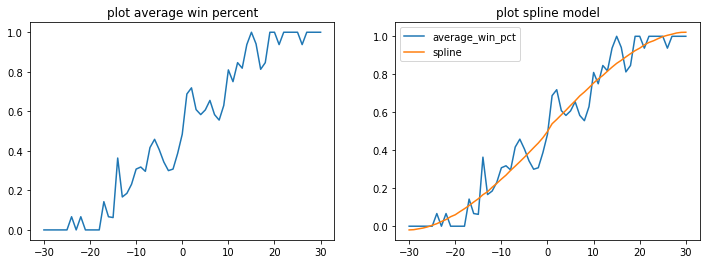

logloss of oof by leak data: 0.4611790649974862


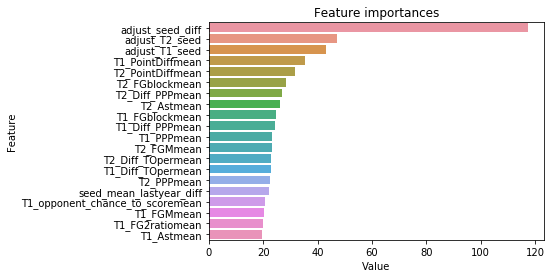

In [167]:
params = {
            'eval_metric': 'mae',
            'booster': 'gbtree',
            'eta': 0.05,
            'subsample': 0.35,
            'colsample_bytree': 0.7,
            'num_parallel_tree': 3,
            'min_child_weight': 40,
            'gamma': 10,
            'max_depth': 3,
            'seed': 42
        } 

if mlflow_config['add_params']['rmse']=='ON':
    params['eval_metric'] = 'rmse'



repeat_cv = int(mlflow_config['add_params']['repeat_cv'])

# scope云々の都合上、mlflow moduleも渡さないといけない気がする。
model = Raddar_Model(tourney_data, features, params, repeat_cv, data_type='leak data')
model.fit()
pred_df = model.prediction(sub)

In [168]:
print(mlflow_config)

{'uri': '../mlflow/mlruns/', 'experiment_name': '4Factors', 'add_params': {'random_seed': 'ON', 'repeat_cv': '3', 'Diff': 'OFF', '4factors': 'ON', 'feature_eng': 'ON', 'del_basic_features': 'OFF', 'Conference': 'ON', 'LocationBy': 'OFF', 'last14days_stats': 'OFF', 'adjust_seed': 'ON', 'groupkfold': 'ON', 'rmse': 'OFF', 'num_boost_round': '25', 'duration_season': '100', 'del_train_corr': 'OFF', 'del_seed_diff': 'ON', 'del_start_T12': 'OFF', 'permtation_imp': 'OFF'}, 'run_id': '65d2a3aff701415f8489b45e47000728', 'tracking': <mlflow.tracking.client.MlflowClient object at 0x10fe397b8>, 'experiment_id': '12'}


# Time to build some models! (not contain leak data)

In [169]:
pred_list = []
duration_season = int(mlflow_config['add_params']['duration_season'])
print('duration_season: ', duration_season)
for season in sub.Season.unique():
    print(f'season: {season}')
    train = tourney_data.loc[tourney_data.Season<season][tourney_data.Season>=season-duration_season].reset_index(drop=True)
    test = sub[sub.Season==season].reset_index(drop=True)
    model = Raddar_Model(train, features, params, repeat_cv, plot_flg=False, data_type=season)
    model.fit()
    pred_list.append(model.prediction(test))
    
pred_df = pd.concat(pred_list, axis=0).reset_index(drop=True)
# pred_df.head()

duration_season:  100
season: 2015


/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-mae:16.0036+0.259692	test-mae:16.0302+1.05418
[50]	train-mae:9.79304+0.165833	test-mae:10.7617+0.937824
[100]	train-mae:8.73272+0.155229	test-mae:10.3636+0.821233
[150]	train-mae:8.09634+0.144544	test-mae:10.275+0.783664
[200]	train-mae:7.59857+0.132918	test-mae:10.2222+0.776035
[250]	train-mae:7.19254+0.108928	test-mae:10.2124+0.75457
[0]	train-mae:15.9968+0.197244	test-mae:16.0228+0.825097
[50]	train-mae:9.84795+0.129632	test-mae:10.7582+0.520027
[100]	train-mae:8.80169+0.113301	test-mae:10.2394+0.499738
[150]	train-mae:8.1581+0.0808258	test-mae:10.1126+0.525212
[200]	train-mae:7.66743+0.0698098	test-mae:10.0665+0.511697
[0]	train-mae:16.0052+0.121938	test-mae:16.0302+0.48005
[50]	train-mae:9.81517+0.102572	test-mae:10.7759+0.58688
[100]	train-mae:8.76186+0.0815627	test-mae:10.354+0.620659
[150]	train-mae:8.11705+0.0792387	test-mae:10.2509+0.5895


/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


logloss of oof by 2015: 0.5057840343604061
season: 2016


/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-mae:15.737+0.260366	test-mae:15.7523+1.07895
[50]	train-mae:9.26844+0.123166	test-mae:10.1551+0.695034
[100]	train-mae:8.18426+0.0775613	test-mae:9.734+0.523309
[150]	train-mae:7.52495+0.0854395	test-mae:9.61465+0.446518
[200]	train-mae:7.01648+0.0988594	test-mae:9.5645+0.391328
[250]	train-mae:6.59829+0.115133	test-mae:9.54721+0.357676
[0]	train-mae:15.7541+0.314626	test-mae:15.7703+1.28787
[50]	train-mae:9.26801+0.137205	test-mae:10.0416+0.629706
[100]	train-mae:8.20226+0.116396	test-mae:9.66469+0.544262
[150]	train-mae:7.54097+0.0944757	test-mae:9.50837+0.529217
[200]	train-mae:7.02645+0.0954263	test-mae:9.48279+0.506343
[0]	train-mae:15.737+0.23021	test-mae:15.7565+0.898646
[50]	train-mae:9.26029+0.184947	test-mae:10.1309+0.798512
[100]	train-mae:8.1856+0.155135	test-mae:9.75195+0.697591
[150]	train-mae:7.53698+0.152848	test-mae:9.68258+0.635551
[200]	train-mae:7.02532+0.17383	test-mae:9.6321+0.616266
[250]	train-mae:6.59478+0.161589	test-mae:9.60116+0.611131


/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


logloss of oof by 2016: 0.46960920679421897
season: 2017


/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-mae:16.0888+0.0986476	test-mae:16.1038+0.314631
[50]	train-mae:9.48668+0.106521	test-mae:10.4738+0.561025
[100]	train-mae:8.30927+0.106053	test-mae:10.0887+0.583013
[150]	train-mae:7.59299+0.10504	test-mae:10.0132+0.605152
[0]	train-mae:16.1019+0.272214	test-mae:16.1281+1.13831
[50]	train-mae:9.50444+0.0598999	test-mae:10.4836+0.4023
[100]	train-mae:8.35348+0.0438464	test-mae:10.053+0.35965
[150]	train-mae:7.65579+0.0413538	test-mae:9.94031+0.3973
[200]	train-mae:7.11094+0.0612659	test-mae:9.89493+0.405464
[250]	train-mae:6.66372+0.0702223	test-mae:9.85331+0.418654
[0]	train-mae:16.1021+0.167002	test-mae:16.1368+0.665963
[50]	train-mae:9.48068+0.0551768	test-mae:10.4363+0.285793
[100]	train-mae:8.33477+0.0540331	test-mae:9.99616+0.217145
[150]	train-mae:7.63752+0.0636372	test-mae:9.83749+0.26653
[200]	train-mae:7.09647+0.0788328	test-mae:9.78381+0.30175
[250]	train-mae:6.64053+0.0703156	test-mae:9.76874+0.322598


/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


logloss of oof by 2017: 0.476529458086314
season: 2018


/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-mae:16.3913+0.147353	test-mae:16.4154+0.679891
[50]	train-mae:9.79521+0.0801288	test-mae:10.6777+0.450125
[100]	train-mae:8.65554+0.0845715	test-mae:10.2747+0.454853
[150]	train-mae:7.97981+0.078931	test-mae:10.1946+0.466833
[200]	train-mae:7.46356+0.0670284	test-mae:10.1708+0.44115
[0]	train-mae:16.4014+0.145932	test-mae:16.425+0.590273
[50]	train-mae:9.78059+0.117464	test-mae:10.6654+0.588605
[100]	train-mae:8.63585+0.0955061	test-mae:10.2604+0.532189
[150]	train-mae:7.97331+0.089932	test-mae:10.1489+0.506676
[200]	train-mae:7.44978+0.0924519	test-mae:10.1144+0.489839
[0]	train-mae:16.4082+0.198281	test-mae:16.4332+0.806415
[50]	train-mae:9.78102+0.0821423	test-mae:10.6747+0.195944
[100]	train-mae:8.64487+0.0800757	test-mae:10.2011+0.2861
[150]	train-mae:7.96744+0.0712665	test-mae:10.1282+0.28166


/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


logloss of oof by 2018: 0.4709874593689357
season: 2019


/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-mae:16.6964+0.179047	test-mae:16.7104+0.734411
[50]	train-mae:9.93203+0.112731	test-mae:10.8414+0.597715
[100]	train-mae:8.84698+0.0755386	test-mae:10.502+0.493199
[150]	train-mae:8.2187+0.0869272	test-mae:10.4513+0.434413
[0]	train-mae:16.6909+0.172419	test-mae:16.7022+0.6926
[50]	train-mae:9.94436+0.141815	test-mae:10.787+0.599824
[100]	train-mae:8.86932+0.126861	test-mae:10.3635+0.452059
[0]	train-mae:16.6876+0.185904	test-mae:16.69+0.769684
[50]	train-mae:9.93115+0.0619291	test-mae:10.7757+0.324939
[100]	train-mae:8.86789+0.0440492	test-mae:10.3895+0.360332


/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


logloss of oof by 2019: 0.4666800243570433


# Submission time!

In [170]:
now = datetime.datetime.strftime(datetime.datetime.now(), "%Y_%m_%d_%H_%M")
pred_df[['ID','pred']].to_csv(os.path.join(output_path, "paris-submission_{}.csv".format(now)), index = None)

# check cv

In [171]:
check_df = tourney_data[['Season', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score', 'T1_seed', 'T2_seed']]
check_df['win'] = np.where((check_df['T1_Score'] - check_df['T2_Score'])>0,1,0)

pred_tmp_df = transform_test(pred_df[['ID','pred', 'T1_PointDiffmean', 'T2_PointDiffmean', 'adjust_seed_diff']])

check_df = pd.merge(pred_tmp_df, check_df, on = ['Season', 'T1_TeamID', 'T2_TeamID'])
check_df.head()

/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

,ID,pred,T1_PointDiffmean,T2_PointDiffmean,adjust_seed_diff,Season,T1_TeamID,T2_TeamID,T1_Score,T2_Score,T1_seed,T2_seed,win
0,2015_3106_3199,0.000000,-0.714286,18.787879,13,2015,3106,3199,49,91,15,2,0
1,2015_3107_3181,0.000000,13.548387,11.645161,9,2015,3107,3181,52,54,13,4,0
2,2015_3110_3234,0.000000,6.125000,7.193548,11,2015,3110,3234,67,75,14,3,0
3,2015_3113_3114,0.603730,12.312500,14.250000,-3,2015,3113,3114,57,54,3,11,1
4,2015_3113_3199,0.370031,12.312500,18.787879,1,2015,3113,3199,65,66,3,2,0


In [172]:
with mlflow.start_run(run_id=mlflow_config['run_id']):
    for season in check_df.Season.unique():
        tmp = check_df[check_df.Season==season]
        score = log_loss(tmp.win,tmp.pred)
        mlflow.log_metric(f'logloss of {season}', score)
        print(f"logloss of {season} : {score}") 
    score = log_loss(check_df.win,check_df.pred)
    mlflow.log_metric(f'logloss of all season', score)
    print(f"logloss of all season : {score}") 

logloss of 2015 : 0.3327379076663171
logloss of 2016 : 0.5503803486693379
logloss of 2017 : 0.43263339421557107
logloss of 2018 : 0.43227508507476775
logloss of 2019 : 0.3648073434235552
logloss of all season : 0.4225668158099099


In [173]:
check_df[check_df.pred<0.5][check_df.T1_seed<check_df.T2_seed]

/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,ID,pred,T1_PointDiffmean,T2_PointDiffmean,adjust_seed_diff,Season,T1_TeamID,T2_TeamID,T1_Score,T2_Score,T1_seed,T2_seed,win
14,2015_3143_3400,0.424874,7.343750,9.687500,-1,2015,3143,3400,70,73,4,5,0
50,2015_3314_3326,0.487619,10.812500,9.575758,-1,2015,3314,3326,86,84,4,5,1
111,2016_3328_3345,0.435039,8.322581,6.516129,-5,2016,3328,3345,61,45,6,11,1
124,2016_3397_3453,0.378791,7.062500,14.625000,-3,2016,3397,3453,59,53,7,10,1
161,2017_3246_3326,0.420101,8.193548,15.562500,-1,2017,3246,3326,68,82,4,5,0
227,2018_3257_3333,0.490944,19.647059,15.500000,-1,2018,3257,3333,76,43,1,6,1
232,2018_3274_3346,0.491221,7.645161,14.031250,-1,2018,3274,3346,72,86,8,9,0


In [174]:
check_df['logloss'] = check_df['pred'].where(check_df['win']==1, 1.0-check_df['pred'])
check_df['logloss'] = check_df['logloss'].map(np.log)
check_df2 = check_df[check_df.logloss<-1.0]
check_df2 = check_df2.sort_values(['Season', 'logloss'], ascending=True)
check_df2

,ID,pred,T1_PointDiffmean,T2_PointDiffmean,adjust_seed_diff,Season,T1_TeamID,T2_TeamID,T1_Score,T2_Score,T1_seed,T2_seed,win,logloss
8,2015_3116_3321,0.148134,4.900000,7.933333,3,2015,3116,3321,57,55,10,7,1,-1.909639
26,2015_3173_3257,0.274371,11.935484,15.290323,-1,2015,3173,3257,82,66,7,3,1,-1.293273
16,2015_3151_3338,0.715920,12.906250,6.600000,-3,2015,3151,3338,40,51,7,10,0,-1.258498
6,2015_3114_3401,0.320586,14.250000,9.593750,5,2015,3114,3401,69,60,11,6,1,-1.137604
35,2015_3211_3333,0.325162,10.258065,15.310345,3,2015,3211,3333,76,64,11,3,1,-1.123433
102,2016_3268_3449,0.975000,24.030303,8.781250,-5,2016,3268,3449,65,74,2,7,0,-3.688879
73,2016_3124_3333,0.918894,24.617647,15.500000,-1,2016,3124,3333,57,60,1,2,0,-2.511993
108,2016_3323_3390,0.838291,19.125000,13.677419,-3,2016,3323,3390,84,90,1,4,0,-1.821959
103,2016_3274_3355,0.834132,10.437500,10.812500,-7,2016,3274,3355,71,74,5,12,0,-1.796563
121,2016_3390_3449,0.798146,13.677419,8.781250,-1,2016,3390,3449,76,85,4,7,0,-1.600209


# check mlflow

In [175]:
mlflow.search_runs()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.logloss of oof by 2015,metrics.logloss of oof by leak data,metrics.logloss of 2019,metrics.logloss of 2016,metrics.logloss of oof by 2016,metrics.logloss of oof by 2019,metrics.logloss of 2015,metrics.logloss of oof by 2018,metrics.logloss of all season,metrics.logloss of 2017,metrics.logloss of oof by 2017,metrics.logloss of 2018,params.LocationBy,params.permtation_imp,params.repeat_cv,params.del_seed_diff,params.adjust_seed,params.del_train_corr,params.rmse,params.del_basic_features,params.random_seed,params.feature_eng,params.Diff,params.Conference,params.groupkfold,params.num_boost_round,params.4factors,params.del_start_T12,params.duration_season,params.last14days_stats,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.git.commit,tags.mlflow.source.name
0,65d2a3aff701415f8489b45e47000728,12,FINISHED,../mlflow/mlruns/12/65d2a3aff701415f8489b45e47...,2020-03-12 14:20:29.183000+00:00,2020-03-12 14:34:19.030000+00:00,0.505784,0.461179,0.364807,0.550380,0.469609,0.466680,0.332738,0.470987,0.422567,0.432633,0.476529,0.432275,OFF,OFF,3,ON,ON,OFF,OFF,OFF,ON,ON,OFF,ON,ON,25,ON,OFF,100,OFF,s.imazeki,LOCAL,97bf8b5f00284af63c34ae660e047ad3cf497369,/Users/s.imazeki/.pyenv/versions/anaconda3-5.3...
1,ad11f901e1074e34ba41a3eef7c08081,12,FINISHED,../mlflow/mlruns/12/ad11f901e1074e34ba41a3eef7...,2020-03-12 14:10:49.606000+00:00,2020-03-12 14:18:09.701000+00:00,0.503107,0.455256,0.376718,0.525013,0.467550,0.463643,0.316988,0.465586,0.414079,0.413591,0.475733,0.438084,OFF,OFF,3,ON,ON,OFF,OFF,OFF,ON,OFF,OFF,ON,ON,25,ON,OFF,100,OFF,s.imazeki,LOCAL,97bf8b5f00284af63c34ae660e047ad3cf497369,/Users/s.imazeki/.pyenv/versions/anaconda3-5.3...
2,d4ee667ea17b4cacaf1befb196b828b3,12,FINISHED,../mlflow/mlruns/12/d4ee667ea17b4cacaf1befb196...,2020-03-12 07:23:23.931000+00:00,2020-03-12 07:53:38.617000+00:00,0.503855,0.456872,0.373795,0.524822,0.467956,0.463817,0.318671,0.465669,0.416498,0.431763,0.473346,0.433439,OFF,OFF,10,ON,ON,OFF,OFF,OFF,ON,OFF,OFF,ON,ON,25,ON,OFF,100,OFF,s.imazeki,LOCAL,97bf8b5f00284af63c34ae660e047ad3cf497369,/Users/s.imazeki/.pyenv/versions/anaconda3-5.3...
3,8ea299fe36f64aa99c69bb27bc03b5be,12,FINISHED,../mlflow/mlruns/12/8ea299fe36f64aa99c69bb27bc...,2020-03-12 07:06:08.283000+00:00,2020-03-12 07:12:45.779000+00:00,0.501923,0.457901,0.378034,0.524339,0.467161,0.464006,0.316529,0.469487,0.416984,0.446269,0.475122,0.419749,OFF,None,3,ON,ON,OFF,OFF,OFF,ON,OFF,OFF,OFF,ON,25,ON,OFF,100,OFF,s.imazeki,LOCAL,97bf8b5f00284af63c34ae660e047ad3cf497369,/Users/s.imazeki/.pyenv/versions/anaconda3-5.3...
4,103c5af9586543e8bb6fc9e26e9b7949,12,FINISHED,../mlflow/mlruns/12/103c5af9586543e8bb6fc9e26e...,2020-03-12 06:57:40.899000+00:00,2020-03-12 07:02:40.280000+00:00,0.506213,0.456965,0.369100,0.526604,0.467886,0.464023,0.321604,0.464848,0.419875,0.436631,0.474646,0.445436,OFF,None,3,ON,ON,OFF,OFF,ON,ON,OFF,OFF,ON,ON,25,ON,OFF,100,OFF,s.imazeki,LOCAL,97bf8b5f00284af63c34ae660e047ad3cf497369,/Users/s.imazeki/.pyenv/versions/anaconda3-5.3...
5,6e4d0e5399954c2db212bdf43ff7226c,12,FINISHED,../mlflow/mlruns/12/6e4d0e5399954c2db212bdf43f...,2020-03-12 06:46:28.287000+00:00,2020-03-12 06:54:29.209000+00:00,0.504914,0.458094,0.371086,0.522604,0.469771,0.463081,0.316124,0.466031,0.411490,0.422903,0.475201,0.424732,OFF,None,3,ON,ON,OFF,OFF,None,ON,OFF,OFF,ON,ON,25,ON,OFF,100,OFF,s.imazeki,LOCAL,97bf8b5f00284af63c34ae660e047ad3cf497369,/Users/s.imazeki/.pyenv/versions/anaconda3-5.3...
6,39f3ed03884f4795810b3e05f8e29401,12,FINISHED,../mlflow/mlruns/12/39f3ed03884f4795810b3e05f8...,2020-03-12 06:30:07.805000+00:00,2020-03-12 06:44:23.657000+00:00,0.508105,0.460297,0.357481,0.551398,0.474677,0.468863,0.334139,0.469969,0.419391,0.427208,0.482002,0.426731,OFF,None,3,ON,ON,OFF,OFF,None,ON,ON,OFF,ON,ON,25,ON,OFF,100,OFF,s.imazeki,LOCAL,97bf8b5f00284af63c34ae660e047ad3cf497369,/Users/s.imazeki/.pyenv/versions/anaconda3-5.3...
7,e6ee1116920a417e824a30ce5efad550,12,FINISHED,../mlflow/mlr